## Making Model Prediction masks

- Get the prediction mask for a specific city tile using the `.pt` model file and the `model class`
- Load the specific city from the dataloader

#### Hyperparameters

In [1]:
ROOT_DIRECTORY = "ChangeDetectionMergedDividedSplit-tif3"
SAVING_DIR = "image_saver"
CD_DIR = "cd2_Output"

if CD_DIR == "cd1_Output":
    CLASSES = ['no_change','vegetation_increase','vegetation_decrease']
elif CD_DIR == "cd2_Output":
    CLASSES = ['no_change', 'water_building', 'water_sparse', 'water_dense',
               'building_water', 'building_sparse', 'building_dense',
               'sparse_water', 'sparse_building', 'sparse_dense',
               'dense_water', 'dense_building', 'dense_sparse']

NUM_WORKERS = 8
BATCH_SIZE = 32
NUM_EPOCHS = 100
#MODEL_NAME = 'snunet_ECAM' 
#'siamunet_conc','siamunet_diff','siamunet_EF','snunet_conc','snunet_ECAM'

# ARCHITECTURE = 'pspnet' # 'unet' or 'linknet', 'pspnet', 'deeplabv3plus'
# SEMANTIC_CLASSES = ['water', 'building', 'sparse_vegetation', 'dense_vegetation']

### Data Loader

In [2]:
import os
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ChangeDetectionDatasetTIF(Dataset):
    def __init__(self, t2019_dir, t2024_dir, mask_dir,classes, transform=None):
        self.t2019_dir = t2019_dir
        self.t2024_dir = t2024_dir
        self.mask_dir = mask_dir
        self.classes = classes  # Change detection classes
        self.transform = transform

        # Load all paths
        self.t2019_paths = sorted([f for f in os.listdir(t2019_dir) if f.endswith('.tif')])
        self.t2024_paths = sorted([f for f in os.listdir(t2024_dir) if f.endswith('.tif')])
        self.mask_paths = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])

    def __len__(self):
        return len(self.t2019_paths)

    def __getitem__(self, index):
        # Load images using rasterio
        with rasterio.open(os.path.join(self.t2019_dir, self.t2019_paths[index])) as src:
            img_t2019 = src.read(out_dtype=np.float32) / 255.0
        with rasterio.open(os.path.join(self.t2024_dir, self.t2024_paths[index])) as src:
            img_t2024 = src.read(out_dtype=np.float32) / 255.0
        # Load masks
        with rasterio.open(os.path.join(self.mask_dir, self.mask_paths[index])) as src:
            cd_mask = src.read(1).astype(np.int64)

        # Convert to PyTorch tensors
        img_t2019 = torch.from_numpy(img_t2019)
        img_t2024 = torch.from_numpy(img_t2024)
        cd_mask = torch.from_numpy(cd_mask)

        # Apply transforms if any
        if self.transform is not None:
            img_t2019 = self.transform(img_t2019)
            img_t2024 = self.transform(img_t2024)

        return img_t2019, img_t2024, cd_mask

def describe_loader(loader_type):
    img2019, img2024, cd_mask = next(iter(loader_type))
    print("Batch size:", loader_type.batch_size)
    print("2019 Image Shape:", img2019.shape)
    print("2024 Image Shape:", img2024.shape)
    print("Change Mask Shape:", cd_mask.shape)
    print("Number of images:", len(loader_type.dataset))
    print("Classes:", loader_type.dataset.classes)
    print("Unique CD values:", torch.unique(cd_mask))

# Create datasets
train_dataset = ChangeDetectionDatasetTIF(
    t2019_dir=f"{ROOT_DIRECTORY}/train/Images/T2019",
    t2024_dir=f"{ROOT_DIRECTORY}/train/Images/T2024",
    mask_dir=f"{ROOT_DIRECTORY}/train/{CD_DIR}",
    classes=CLASSES
)

val_dataset = ChangeDetectionDatasetTIF(
    t2019_dir=f"{ROOT_DIRECTORY}/val/Images/T2019",
    t2024_dir=f"{ROOT_DIRECTORY}/val/Images/T2024",
    mask_dir=f"{ROOT_DIRECTORY}/val/{CD_DIR}",
    classes=CLASSES
)

test_dataset = ChangeDetectionDatasetTIF(
    t2019_dir=f"{ROOT_DIRECTORY}/test/Images/T2019",
    t2024_dir=f"{ROOT_DIRECTORY}/test/Images/T2024",
    mask_dir=f"{ROOT_DIRECTORY}/test/{CD_DIR}",
    classes=CLASSES
)

# Create dataloaders
### KEEP SHUFFLE=FALSE (to get same sample index each time)
num_workers = 8
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)#,num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)#,num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#,num_workers=num_workers, pin_memory=True)

print("------------Train-----------")
describe_loader(train_loader)
print("------------Val------------")
describe_loader(val_loader)
print("------------Test------------")
describe_loader(test_loader)

------------Train-----------
Batch size: 32
2019 Image Shape: torch.Size([32, 3, 256, 256])
2024 Image Shape: torch.Size([32, 3, 256, 256])
Change Mask Shape: torch.Size([32, 256, 256])
Number of images: 3653
Classes: ['no_change', 'water_building', 'water_sparse', 'water_dense', 'building_water', 'building_sparse', 'building_dense', 'sparse_water', 'sparse_building', 'sparse_dense', 'dense_water', 'dense_building', 'dense_sparse']
Unique CD values: tensor([ 0,  1,  4,  5,  6,  8,  9, 11, 12])
------------Val------------
Batch size: 32
2019 Image Shape: torch.Size([32, 3, 256, 256])
2024 Image Shape: torch.Size([32, 3, 256, 256])
Change Mask Shape: torch.Size([32, 256, 256])
Number of images: 784
Classes: ['no_change', 'water_building', 'water_sparse', 'water_dense', 'building_water', 'building_sparse', 'building_dense', 'sparse_water', 'sparse_building', 'sparse_dense', 'dense_water', 'dense_building', 'dense_sparse']
Unique CD values: tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 1

### Model Definition

#### ALL Siamunets

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d
import torch.optim as optim

########## SiamUnet_conc ##########
class SiamUnet_conc(nn.Module):
    """SiamUnet_conc segmentation network for multiclass change detection."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_conc, self).__init__()

        self.input_nbr = input_nbr
        self.label_nbr = label_nbr  # Added for clarity

        # Encoder Layers
        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        # Decoder Layers
        self.conv43d = nn.ConvTranspose2d(384, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(192, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(96, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(48, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        # Changed to use label_nbr instead of hardcoded value
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        # Multiclass activation (Softmax instead of LogSoftmax)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x1, x2):
        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)

        ####################################################
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)

        ####################################################
        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43_1, x43_2), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33_1, x33_2), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22_1, x22_2), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12_1, x12_2), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

######### SiamUnet_diff #########
class SiamUnet_diff(nn.Module):
    """SiamUnet_diff segmentation network for multiclass change detection."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_diff, self).__init__()

        self.input_nbr = input_nbr
        self.label_nbr = label_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        # Changed to output label_nbr channels for multiclass
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        # Changed from LogSoftmax to regular Softmax
        self.sm = nn.Softmax(dim=1)

    def forward(self, x1, x2):
        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)

        ####################################################
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)

        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), torch.abs(x43_1 - x43_2)), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), torch.abs(x33_1 - x33_2)), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), torch.abs(x22_1 - x22_2)), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), torch.abs(x12_1 - x12_2)), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)
    
######### SiamUnet_EF #########
class SiamUnet_EF(nn.Module):
    """Multiclass UNet segmentation network for change detection."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_EF, self).__init__()

        self.input_nbr = input_nbr * 2  # Multiply by 2 since we concatenate two images
        self.label_nbr = label_nbr

        # Encoder Layers
        self.conv11 = nn.Conv2d(input_nbr * 2, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        # Decoder Layers
        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        # Change output layer to match number of classes
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        # Change to Softmax for multiclass
        self.sm = nn.Softmax(dim=1)

    def forward(self, x1, x2):
        """Forward method."""
        # Initial concatenation of input images (early fusion)
        x = torch.cat((x1, x2), dim=1)

        # Stage 1 - Encoder
        x11 = self.do11(F.relu(self.bn11(self.conv11(x))))
        x12 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2 - Encoder
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3 - Encoder
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

        # Stage 4 - Encoder
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)

        # Stage 4d - Decoder
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43.size(3) - x4d.size(3), 0, x43.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d - Decoder
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33.size(3) - x3d.size(3), 0, x33.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d - Decoder
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d - Decoder
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

########### SNUNet_conc ###########
class conv_block_nested(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        identity = x
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x + identity)
        return output

class up(nn.Module):
    def __init__(self, in_ch, bilinear=True):
        super(up, self).__init__()
        self.up = nn.Upsample(scale_factor=2,
                            mode='bilinear',
                            align_corners=True) if bilinear else \
                 nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

    def forward(self, x):
        x = self.up(x)
        return x

class Siam_NestedUNet_Conc(nn.Module):
    def __init__(self, in_ch=3, out_ch=3):
        super(Siam_NestedUNet_Conc, self).__init__()
        torch.nn.Module.dump_patches = True
        n1 = 32     # Initial number of channels
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder path for both images
        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.Up1_0 = up(filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.Up2_0 = up(filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.Up3_0 = up(filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])
        self.Up4_0 = up(filters[4])

        # Nested dense connections with batch norm
        self.conv0_1 = conv_block_nested(filters[0] * 2 + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] * 2 + filters[2], filters[1], filters[1])
        self.Up1_1 = up(filters[1])
        self.conv2_1 = conv_block_nested(filters[2] * 2 + filters[3], filters[2], filters[2])
        self.Up2_1 = up(filters[2])
        self.conv3_1 = conv_block_nested(filters[3] * 2 + filters[4], filters[3], filters[3])
        self.Up3_1 = up(filters[3])

        self.conv0_2 = conv_block_nested(filters[0] * 3 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1] * 3 + filters[2], filters[1], filters[1])
        self.Up1_2 = up(filters[1])
        self.conv2_2 = conv_block_nested(filters[2] * 3 + filters[3], filters[2], filters[2])
        self.Up2_2 = up(filters[2])

        self.conv0_3 = conv_block_nested(filters[0] * 4 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1] * 4 + filters[2], filters[1], filters[1])
        self.Up1_3 = up(filters[1])

        self.conv0_4 = conv_block_nested(filters[0] * 5 + filters[1], filters[0], filters[0])

        # Add batch normalization to deep supervision outputs
        self.final1 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0] // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0] // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0] // 2, out_ch, kernel_size=1)
        )

        self.final2 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0] // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0] // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0] // 2, out_ch, kernel_size=1)
        )

        self.final3 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0] // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0] // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0] // 2, out_ch, kernel_size=1)
        )

        self.final4 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0] // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0] // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0] // 2, out_ch, kernel_size=1)
        )

        # Final combination layer with better feature extraction
        self.conv_final = nn.Sequential(
            nn.Conv2d(out_ch * 4, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], filters[0] // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0] // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0] // 2, out_ch, kernel_size=1)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Use Xavier/Glorot initialization for final layers
                if m.kernel_size[0] == 1:
                    nn.init.xavier_uniform_(m.weight)
                else:
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, xA, xB):
        # Encoder Path A
        x0_0A = self.conv0_0(xA)
        x1_0A = self.conv1_0(self.pool(x0_0A))
        x2_0A = self.conv2_0(self.pool(x1_0A))
        x3_0A = self.conv3_0(self.pool(x2_0A))

        # Encoder Path B
        x0_0B = self.conv0_0(xB)
        x1_0B = self.conv1_0(self.pool(x0_0B))
        x2_0B = self.conv2_0(self.pool(x1_0B))
        x3_0B = self.conv3_0(self.pool(x2_0B))
        x4_0B = self.conv4_0(self.pool(x3_0B))

        # Nested Dense Connections and Decoder Path
        x0_1 = self.conv0_1(torch.cat([x0_0A, x0_0B, self.Up1_0(x1_0B)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0A, x1_0B, self.Up2_0(x2_0B)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0A, x0_0B, x0_1, self.Up1_1(x1_1)], 1))

        x2_1 = self.conv2_1(torch.cat([x2_0A, x2_0B, self.Up3_0(x3_0B)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0A, x1_0B, x1_1, self.Up2_1(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0A, x0_0B, x0_1, x0_2, self.Up1_2(x1_2)], 1))

        x3_1 = self.conv3_1(torch.cat([x3_0A, x3_0B, self.Up4_0(x4_0B)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0A, x2_0B, x2_1, self.Up3_1(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0A, x1_0B, x1_1, x1_2, self.Up2_2(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0A, x0_0B, x0_1, x0_2, x0_3, self.Up1_3(x1_3)], 1))

        # Get outputs at different scales
        output1 = self.final1(x0_1)
        output2 = self.final2(x0_2)
        output3 = self.final3(x0_3)
        output4 = self.final4(x0_4)

        # Combine outputs
        output = self.conv_final(torch.cat([output1, output2, output3, output4], 1))

        # Return logits without softmax for CrossEntropyLoss
        return output
    
########### SNUNet_ECAM ###########
class conv_block_nested(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        identity = x
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x + identity)
        return output

class up(nn.Module):
    def __init__(self, in_ch, bilinear=True):
        super(up, self).__init__()
        self.up = nn.Upsample(scale_factor=2,
                            mode='bilinear',
                            align_corners=True) if bilinear else \
                 nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

    def forward(self, x):
        x = self.up(x)
        return x

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        reduced_channels = max(8, in_channels // ratio)
        self.fc1 = nn.Conv2d(in_channels, reduced_channels, 1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SNUNet_ECAM(nn.Module):
    def __init__(self, in_ch=3, out_ch=3):
        super(SNUNet_ECAM, self).__init__()
        n1 = 32
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 8]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.Up1_0 = up(filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.Up2_0 = up(filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.Up3_0 = up(filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])
        self.Up4_0 = up(filters[4])

        # Decoder with correct input channels
        self.conv0_1 = conv_block_nested(filters[0] * 2 + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] * 2 + filters[2], filters[1], filters[1])
        self.Up1_1 = up(filters[1])
        self.conv2_1 = conv_block_nested(filters[2] * 2 + filters[3], filters[2], filters[2])
        self.Up2_1 = up(filters[2])
        self.conv3_1 = conv_block_nested(filters[3] * 2 + filters[4], filters[3], filters[3])
        self.Up3_1 = up(filters[3])

        self.conv0_2 = conv_block_nested(filters[0] * 3 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1] * 3 + filters[2], filters[1], filters[1])
        self.Up1_2 = up(filters[1])
        self.conv2_2 = conv_block_nested(filters[2] * 3 + filters[3], filters[2], filters[2])
        self.Up2_2 = up(filters[2])

        self.conv0_3 = conv_block_nested(filters[0] * 4 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1] * 4 + filters[2], filters[1], filters[1])
        self.Up1_3 = up(filters[1])

        self.conv0_4 = conv_block_nested(filters[0] * 5 + filters[1], filters[0], filters[0])

        # Channel attention modules
        self.ca = ChannelAttention(filters[0] * 4, ratio=16)
        self.ca1 = ChannelAttention(filters[0], ratio=8)

        # Final convolution
        self.conv_final = nn.Sequential(
            nn.Conv2d(filters[0] * 4, filters[0], kernel_size=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], out_ch, kernel_size=1)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, xA, xB):
        # Encoder path A
        x0_0A = self.conv0_0(xA)
        x1_0A = self.conv1_0(self.pool(x0_0A))
        x2_0A = self.conv2_0(self.pool(x1_0A))
        x3_0A = self.conv3_0(self.pool(x2_0A))

        # Encoder path B
        x0_0B = self.conv0_0(xB)
        x1_0B = self.conv1_0(self.pool(x0_0B))
        x2_0B = self.conv2_0(self.pool(x1_0B))
        x3_0B = self.conv3_0(self.pool(x2_0B))
        x4_0B = self.conv4_0(self.pool(x3_0B))

        # Dense connections level 1
        x0_1 = self.conv0_1(torch.cat([x0_0A, x0_0B, self.Up1_0(x1_0B)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0A, x1_0B, self.Up2_0(x2_0B)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0A, x2_0B, self.Up3_0(x3_0B)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0A, x3_0B, self.Up4_0(x4_0B)], 1))

        # Dense connections level 2
        x0_2 = self.conv0_2(torch.cat([x0_0A, x0_0B, x0_1, self.Up1_1(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0A, x1_0B, x1_1, self.Up2_1(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0A, x2_0B, x2_1, self.Up3_1(x3_1)], 1))

        # Dense connections level 3
        x0_3 = self.conv0_3(torch.cat([x0_0A, x0_0B, x0_1, x0_2, self.Up1_2(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0A, x1_0B, x1_1, x1_2, self.Up2_2(x2_2)], 1))

        # Final dense connections
        x0_4 = self.conv0_4(torch.cat([x0_0A, x0_0B, x0_1, x0_2, x0_3, self.Up1_3(x1_3)], 1))

        # Combine features
        out = torch.cat([x0_1, x0_2, x0_3, x0_4], 1)
        intra = torch.sum(torch.stack((x0_1, x0_2, x0_3, x0_4)), dim=0)

        # Apply attention
        ca1 = self.ca1(intra)
        out = self.ca(out) * (out + ca1.repeat(1, 4, 1, 1))

        # Final convolution
        out = self.conv_final(out)

        return out

#### All PCC

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

class ChangeDetectionModel(nn.Module):
    def __init__(self, architecture='unet', encoder='resnet34', input_channels=3, num_semantic_classes=4, num_cd_classes=3):
        super().__init__()
        # Semantic segmentation models for each timestamp
        if architecture.lower() == 'unet':
            self.sem_model = smp.Unet(
                encoder_name=encoder,
                encoder_weights="imagenet",
                in_channels=input_channels,
                classes=num_semantic_classes,
            )
        elif architecture.lower() == 'linknet':
            self.sem_model = smp.Linknet(
                encoder_name=encoder,
                encoder_weights="imagenet",
                in_channels=input_channels,
                classes=num_semantic_classes,
            )
        elif architecture.lower() == 'pspnet':
            self.sem_model = smp.PSPNet(
                encoder_name=encoder,
                encoder_weights="imagenet",
                in_channels=input_channels,
                classes=num_semantic_classes,
            )
        elif architecture.lower() == 'deeplabv3plus':
            self.sem_model = smp.DeepLabV3Plus(
                encoder_name=encoder,
                encoder_weights="imagenet",
                in_channels=input_channels,
                classes=num_semantic_classes,
            )

        self.change_head = nn.Sequential(
            nn.Conv2d(num_semantic_classes*2, 64, kernel_size=3, padding=1),  # Update input channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_cd_classes, kernel_size=1),  # Update output channels
            nn.Dropout(0.3)
        )

    def forward(self, x1, x2):
        # Get semantic features for both timestamps
        sem_feat1 = self.sem_model(x1)
        sem_feat2 = self.sem_model(x2)

        # Concatenate semantic features
        combined_feat = torch.cat([sem_feat1, sem_feat2], dim=1)

        # Get change detection output
        change_out = self.change_head(combined_feat)

        return sem_feat1, sem_feat2, change_out

#### STANet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleList

class PAMBlock(nn.Module):
    """The basic implementation for self-attention block/non-local block"""
    def __init__(self, in_channels, key_channels, value_channels, scale=1, ds=1):
        super(PAMBlock, self).__init__()
        self.scale = scale
        self.ds = ds
        self.pool = nn.AvgPool2d(self.ds)
        self.in_channels = in_channels
        self.key_channels = key_channels
        self.value_channels = value_channels

        self.f_key = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.key_channels,
                     kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(self.key_channels)
        )
        self.f_query = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.key_channels,
                     kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(self.key_channels)
        )
        self.f_value = nn.Conv2d(in_channels=self.in_channels, out_channels=self.value_channels,
                                kernel_size=1, stride=1, padding=0)

    def forward(self, input):
        x = input
        if self.ds != 1:
            x = self.pool(input)

        batch_size, c, h, w = x.size(0), x.size(1), x.size(2), x.size(3) // 2

        local_y = []
        local_x = []
        step_h, step_w = h // self.scale, w // self.scale
        for i in range(0, self.scale):
            for j in range(0, self.scale):
                start_x, start_y = i * step_h, j * step_w
                end_x, end_y = min(start_x + step_h, h), min(start_y + step_w, w)
                if i == (self.scale - 1):
                    end_x = h
                if j == (self.scale - 1):
                    end_y = w
                local_x += [start_x, end_x]
                local_y += [start_y, end_y]

        value = self.f_value(x)
        query = self.f_query(x)
        key = self.f_key(x)

        value = torch.stack([value[:, :, :, :w], value[:, :, :, w:]], 4)
        query = torch.stack([query[:, :, :, :w], query[:, :, :, w:]], 4)
        key = torch.stack([key[:, :, :, :w], key[:, :, :, w:]], 4)

        local_block_cnt = 2 * self.scale * self.scale

        def self_attention(value_local, query_local, key_local):
            batch_size_new = value_local.size(0)
            h_local, w_local = value_local.size(2), value_local.size(3)
            value_local = value_local.contiguous().view(batch_size_new, self.value_channels, -1)

            query_local = query_local.contiguous().view(batch_size_new, self.key_channels, -1)
            query_local = query_local.permute(0, 2, 1)
            key_local = key_local.contiguous().view(batch_size_new, self.key_channels, -1)

            sim_map = torch.bmm(query_local, key_local)
            sim_map = (self.key_channels ** -.5) * sim_map
            sim_map = F.softmax(sim_map, dim=-1)

            context_local = torch.bmm(value_local, sim_map.permute(0, 2, 1))
            context_local = context_local.view(batch_size_new, self.value_channels, h_local, w_local, 2)
            return context_local

        v_list = [value[:, :, local_x[i]:local_x[i + 1], local_y[i]:local_y[i + 1]] for i in range(0, local_block_cnt, 2)]
        v_locals = torch.cat(v_list, dim=0)
        q_list = [query[:, :, local_x[i]:local_x[i + 1], local_y[i]:local_y[i + 1]] for i in range(0, local_block_cnt, 2)]
        q_locals = torch.cat(q_list, dim=0)
        k_list = [key[:, :, local_x[i]:local_x[i + 1], local_y[i]:local_y[i + 1]] for i in range(0, local_block_cnt, 2)]
        k_locals = torch.cat(k_list, dim=0)
        context_locals = self_attention(v_locals, q_locals, k_locals)

        context_list = []
        for i in range(0, self.scale):
            row_tmp = []
            for j in range(0, self.scale):
                left = batch_size * (j + i * self.scale)
                right = batch_size * (j + i * self.scale) + batch_size
                tmp = context_locals[left:right]
                row_tmp.append(tmp)
            context_list.append(torch.cat(row_tmp, 3))

        context = torch.cat(context_list, 2)
        context = torch.cat([context[:, :, :, :, 0], context[:, :, :, :, 1]], 3)

        if self.ds != 1:
            context = F.interpolate(context, [h * self.ds, 2 * w * self.ds])

        return context

class PAM(nn.Module):
    """PAM (Position Attention Module)"""
    def __init__(self, in_channels, out_channels, sizes=([1]), ds=1):
        super(PAM, self).__init__()
        self.group = len(sizes)
        self.stages = []
        self.ds = ds
        self.value_channels = out_channels
        self.key_channels = out_channels // 8

        self.stages = nn.ModuleList(
            [PAMBlock(in_channels, self.key_channels, self.value_channels, size, self.ds)
             for size in sizes])
        self.conv_bn = nn.Sequential(
            nn.Conv2d(in_channels * self.group, out_channels, kernel_size=1, padding=0, bias=False),
        )

    def forward(self, feats):
        priors = [stage(feats) for stage in self.stages]
        context = []
        for i in range(0, len(priors)):
            context += [priors[i]]
        output = self.conv_bn(torch.cat(context, 1))
        return output

class BAM(nn.Module):
    """Basic self-attention module"""
    def __init__(self, in_dim, ds=8, activation=nn.ReLU):
        super(BAM, self).__init__()
        self.chanel_in = in_dim
        self.key_channel = self.chanel_in // 8
        self.activation = activation
        self.ds = ds
        self.pool = nn.AvgPool2d(self.ds)
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input):
        x = self.pool(input)
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        energy = (self.key_channel ** -.5) * energy
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)
        out = F.interpolate(out, [width * self.ds, height * self.ds])
        out = out + input
        return out

class CDSA(nn.Module):
    """Self attention module for change detection"""
    def __init__(self, in_c, ds=1, mode='BAM'):
        super(CDSA, self).__init__()
        self.in_C = in_c
        self.ds = ds
        self.mode = mode
        if self.mode == 'BAM':
            self.Self_Att = BAM(self.in_C, ds=self.ds)
        elif self.mode == 'PAM':
            self.Self_Att = PAM(in_channels=self.in_C, out_channels=self.in_C, sizes=[1, 2, 4, 8], ds=self.ds)
        elif self.mode == 'None':
            self.Self_Att = nn.Identity()

    def forward(self, x1, x2):
        height = x1.shape[3]
        x = torch.cat((x1, x2), 3)
        x = self.Self_Att(x)
        return x[:, :, :, 0:height], x[:, :, :, height:]

class STANet(nn.Module):
    """STANet for multiclass change detection"""
    def __init__(self, input_channels=3, hidden_channels=32, num_cd_classes=3, attention_mode='BAM'):
        super(STANet, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.num_cd_classes = num_cd_classes
        self.attention_mode = attention_mode

        # Encoder/Backbone layers
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels*2)
        self.conv3 = nn.Conv2d(hidden_channels*2, hidden_channels*4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_channels*4)

        # Self-attention module
        self.sa = CDSA(in_c=hidden_channels*4, ds=1, mode=attention_mode)

        # Decoder layers
        self.upconv1 = nn.ConvTranspose2d(hidden_channels*8, hidden_channels*4, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upbn1 = nn.BatchNorm2d(hidden_channels*4)
        self.upconv2 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upbn2 = nn.BatchNorm2d(hidden_channels*2)
        self.upconv3 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upbn3 = nn.BatchNorm2d(hidden_channels)

        # Final classification layer
        self.final_conv = nn.Conv2d(hidden_channels, num_cd_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def encode(self, x):
        # Encoder path
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        return x

    def decode(self, x):
        # Decoder path
        x = F.relu(self.upbn1(self.upconv1(x)))
        x = F.relu(self.upbn2(self.upconv2(x)))
        x = F.relu(self.upbn3(self.upconv3(x)))
        return x

    def forward(self, x1, x2):
        # Encode both images
        feat1 = self.encode(x1)
        feat2 = self.encode(x2)

        # Apply self-attention
        att1, att2 = self.sa(feat1, feat2)

        # Concatenate attended features
        combined = torch.cat([att1, att2], dim=1)

        # Decode
        decoded = self.decode(combined)

        # Final classification
        out = self.final_conv(decoded)

        # Only apply softmax during inference
        if not self.training:
            out = self.softmax(out)

        return out

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

#### Strategy 3

In [3]:
import torch
import segmentation_models_pytorch as smp

class Strategy3Model:
    """Combined CD and LCM model with checkpoint management"""
    def __init__(self, cd_architecture='unet', lcm_architecture='unet',
                 cd_encoder='resnet34', lcm_encoder='resnet34',
                 input_channels=3, num_cd_classes=13, num_semantic_classes=4):
        # Initialize CD model
        self.cd_model = self._create_cd_model(
            architecture=cd_architecture,
            encoder=cd_encoder,
            input_channels=input_channels
        )
        # Initialize LCM model
        self.lcm_model = self._create_lcm_model(
            architecture=lcm_architecture,
            encoder=lcm_encoder,
            input_channels=input_channels,
            num_semantic_classes=num_semantic_classes
        )

    def _create_cd_model(self, architecture, encoder, input_channels):
        """Create binary change detection model"""
        if architecture.lower() == 'unet':
            model = smp.Unet(
                encoder_name=encoder,
                encoder_weights='imagenet',
                in_channels=input_channels*2,  # Concatenated images
                classes=1,  # Binary output,
                encoder_depth=4,  # Reduce depth (def=5)
                decoder_channels=(256, 128, 64, 32)  # Reduce channels(def=(256, 128, 64, 32, 16))

            )
        elif architecture.lower() == 'deeplabv3plus':
            model = smp.DeepLabV3Plus(
                encoder_name=encoder,
                encoder_weights='imagenet',
                in_channels=input_channels*2,
                classes=1,
            )
        # Add more architectures as needed
        return model

    def _create_lcm_model(self, architecture, encoder, input_channels, num_semantic_classes=4):
        """Create land cover mapping model"""
        if architecture.lower() == 'unet':
            model = smp.Unet(
                encoder_name=encoder,
                encoder_weights='imagenet',
                in_channels=input_channels,
                classes=num_semantic_classes,  # 4 land cover classes
            )
        elif architecture.lower() == 'deeplabv3plus':
            model = smp.DeepLabV3Plus(
                encoder_name=encoder,
                encoder_weights='imagenet',
                in_channels=input_channels,
                classes=num_semantic_classes,
            )
        # Add more architectures as needed
        return model

    def to(self, device):
        """Move models to device"""
        self.cd_model = self.cd_model.to(device)
        self.lcm_model = self.lcm_model.to(device)
        return self

    def train(self):
        """Set models to training mode"""
        self.cd_model.train()
        self.lcm_model.train()

    def eval(self):
        """Set models to evaluation mode"""
        self.cd_model.eval()
        self.lcm_model.eval()

def create_semantic_change_mask(binary_pred, lcm_pred_2019, lcm_pred_2024):
    """Convert binary change + LCM predictions to 13-class semantic change mask.

    Optimized version using vectorized operations and pre-computed lookup tables.

    Args:
        binary_pred: Binary change prediction tensor (B, 1, H, W)
        lcm_pred_2019: Land cover prediction tensor for 2019 (B, C, H, W)
        lcm_pred_2024: Land cover prediction tensor for 2024 (B, C, H, W)

    Returns:
        Semantic change mask tensor (B, H, W) with values 0-12
    """
    device = binary_pred.device
    batch_size = binary_pred.shape[0]
    height = binary_pred.shape[2]
    width = binary_pred.shape[3]

    # Pre-compute land cover predictions - do this once
    lcm_2019 = torch.argmax(lcm_pred_2019, dim=1)  # (B, H, W)
    lcm_2024 = torch.argmax(lcm_pred_2024, dim=1)  # (B, H, W)

    # Create the change mask - use threshold without squeeze/unsqueeze
    change_mask = binary_pred[:, 0] > 0.5  # (B, H, W)

    # Initialize output tensor
    semantic_mask = torch.zeros((batch_size, height, width), device=device, dtype=torch.long)

    # Create transition matrix lookup table - speeds up class mapping
    # Format: from_class * num_cd_classes + to_class = semantic_class
    num_cd_classes = 4  # Water, Building, Sparse, Dense
    transitions = torch.full((num_cd_classes * num_cd_classes,), 0, device=device)

    # Populate transition matrix - all transitions not listed default to 0 (no change)
    transition_map = {
        (0, 1): 1,   # Water → Building
        (0, 2): 2,   # Water → Sparse
        (0, 3): 3,   # Water → Dense
        (1, 0): 4,   # Building → Water
        (1, 2): 5,   # Building → Sparse
        (1, 3): 6,   # Building → Dense
        (2, 0): 7,   # Sparse → Water
        (2, 1): 8,   # Sparse → Building
        (2, 3): 9,   # Sparse → Dense
        (3, 0): 10,  # Dense → Water
        (3, 1): 11,  # Dense → Building
        (3, 2): 12,  # Dense → Sparse
    }

    for (from_idx, to_idx), semantic_idx in transition_map.items():
        transitions[from_idx * num_cd_classes + to_idx] = semantic_idx

    # Vectorized computation of semantic classes
    # Only compute for changed pixels to save memory
    changed_pixels = change_mask.nonzero(as_tuple=True)
    if len(changed_pixels[0]) > 0:
        from_classes = lcm_2019[changed_pixels]  # (N,)
        to_classes = lcm_2024[changed_pixels]    # (N,)

        # Compute transition indices
        transition_indices = from_classes * num_cd_classes + to_classes  # (N,)

        # Look up semantic classes from transition matrix
        semantic_classes = transitions[transition_indices]  # (N,)

        # Assign semantic classes to output mask
        semantic_mask[changed_pixels] = semantic_classes

    return semantic_mask

#### Strategy 4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskChangeDetectionModel(nn.Module):
    def __init__(self, input_channels, num_semantic_classes, num_change_classes):
        super().__init__()

        # Shared Encoder
        self.encoder = nn.Sequential(
            # Initial block
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Second block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Land Cover Mapping Decoder (shared weights)
        self.lcm_decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_semantic_classes, kernel_size=4, stride=2, padding=1)
        )

        # Change Detection Decoder
        self.cd_decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_change_classes, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x1, x2):
        # Ensure input images are the same size
        assert x1.shape == x2.shape, "Input images must have the same dimensions"

        # Encode both images
        enc1 = self.encoder(x1)
        enc2 = self.encoder(x2)

        # Land Cover Mapping for both time periods
        lcm1 = self.lcm_decoder(enc1)
        lcm2 = self.lcm_decoder(enc2)

        # Change Detection (using difference of encodings)
        cd_input = torch.abs(enc1 - enc2)  # Or torch.cat([enc1, enc2], dim=1)
        cd_output = self.cd_decoder(cd_input)

        return lcm1, lcm2, cd_output

### Define the checkpoint path, model name etc

#### SiamUnets all architectures

In [ ]:
# # Initialize and train the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_cd_classes = len(CLASSES)  #num classes in change mask
# weighting_method = 'square_balanced'  #balanced,square_balanced,custom

# weighted_metrics = True if num_cd_classes > 5 else False   #True for 13 classes,False for 3 classes

# #13 classes
# #strategy = 'st2' 
# #name = f"{strategy}_{MODEL_NAME}-{num_cd_classes}_classes_{NUM_EPOCHS}" #13 classes

# #3 classes
# strategy = 'st1' 
# name = f"{strategy}_{MODEL_NAME}_{NUM_EPOCHS}" 

# # Initialize model
# checkpoint_path = f'{SAVING_DIR}/best_{name}.pt'

# if MODEL_NAME == 'siamunet_conc':
#     model = SiamUnet_conc(input_nbr=3, label_nbr=num_cd_classes).to(device)
# elif MODEL_NAME == 'siamunet_diff':
#     model = SiamUnet_diff(input_nbr=3, label_nbr=num_cd_classes).to(device)
# elif MODEL_NAME == 'siamunet_EF':
#     model = SiamUnet_EF(input_nbr=3, label_nbr=num_cd_classes).to(device)
# elif MODEL_NAME == 'snunet_conc':
#     model = Siam_NestedUNet_Conc(in_ch=3, out_ch=num_cd_classes).to(device)
# elif MODEL_NAME == 'snunet_ECAM':
#     model = SNUNet_ECAM(in_ch=3, out_ch=num_cd_classes).to(device)

#### PCC all architectures

In [ ]:
# # Initialize model and device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# num_cd_classes = len(CLASSES)   # Change Detection classes (3 for cd1, 13 for cd2)
# num_semantic_classes = len(SEMANTIC_CLASSES)   # Semantic segmentation LCM classes (4 for both)
# weighted_metrics = True if num_cd_classes > 5 else False   #True for 13 classes,False for 3 classes

# #name = f'{ARCHITECTURE}-{num_cd_classes}_classes_{NUM_EPOCHS}'  #3 classes
# name = f'{ARCHITECTURE}_{NUM_EPOCHS}'  #13 classes
# checkpoint_path = f'{SAVING_DIR}/best_{name}_epochs.pt'

# # Create model
# model = ChangeDetectionModel(
#     architecture=ARCHITECTURE,encoder='resnet34',
#     input_channels=3,num_cd_classes=num_cd_classes,
#     num_semantic_classes=num_semantic_classes
# ).to(device)

#### STANet

In [ ]:
# # Initialize and train the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_name1 = 'stanet'
# attention_mode = 'None' # 'BAM' 'PAM' 'None'
# num_cd_classes = 3  #num classes in change mask
# num_epochs = 100
# weighting_method = 'square_balanced' #'custom'
# loss = 'CE' #'focal' #'bcl'
# checkpoint_path = f'{SAVING_DIR}/best_{model_name1}_{attention_mode}-{num_cd_classes}_classes_{num_epochs}.pt'

# # Initialize model and data loaders
# model = STANet(input_channels=3, hidden_channels=32, 
#                num_cd_classes=num_cd_classes, 
#                attention_mode=attention_mode)

#### Strategy 3

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_cd_classes=13   #Change Detection classes (3 for cd1, 13 for cd2)
num_semantic_classes=4  #Semantic Segmentation LCM classes (4 for both)
num_epochs = 100
weighting_method = 'square_balanced'
loss = 'CE' #'CE'
checkpoint_path = f'{SAVING_DIR}/best_Strat3_{num_epochs}_epochs.pt'  #'models/strategy3_model.pt'

# Create model
model = Strategy3Model(
    cd_architecture='unet',
    lcm_architecture='unet',
    cd_encoder='resnet34',
    lcm_encoder='resnet34',
    input_channels=3,
    num_cd_classes=num_cd_classes,
    num_semantic_classes=num_semantic_classes
).to(device)

#### Strategy 4

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model configuration
input_channels = 3
num_semantic_classes = 4 #len(SEMANTIC_CLASSES)
num_change_classes = 13 #len(CLASSES)
num_cd_classes = num_change_classes
num_epochs = 100

# Create model
model = MultiTaskChangeDetectionModel(
    input_channels=input_channels,
    num_semantic_classes=num_semantic_classes,
    num_change_classes=num_change_classes
).to(device)

# Define checkpoint paths
lcm_checkpoint_path = f'{SAVING_DIR}/best_lcm_model_{num_epochs}.pt'
full_checkpoint_path = f'{SAVING_DIR}/best_full_model_{num_epochs}.pt'

### Model Testing

C:\Users\omkar\AppData\Local\Temp\ipykernel_13944\3059767274.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

Loading checkpoint from image_saver/best_Strat3_100_epochs.pt
Successfully loaded both CD and LCM models


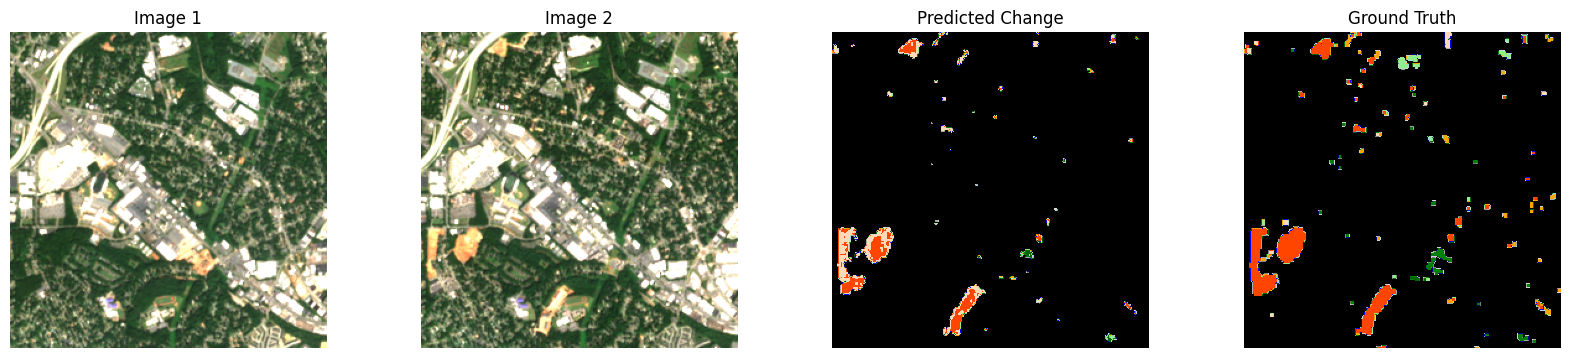

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def find_sample_idx_by_filename(test_loader, filename):
    """
    Find the sample index for a given filename in the test_loader dataset.
    
    Args:
        test_loader: DataLoader containing the test data
        filename: Filename to search for (without path)
    
    Returns:
        int: Index of the sample, or -1 if not found
    """
    # Access the underlying dataset
    dataset = test_loader.dataset
    
    # Search through all paths in the dataset
    for idx in range(len(dataset)):
        # Get the t2019 paths from your dataset (adjust this based on your dataset structure)
        current_path = dataset.t2019_paths[idx]
        current_filename = os.path.basename(current_path)
        
        # Check if this is the file we're looking for
        if filename in current_filename:
            return idx
    
    return -1

def visualize_single_sample(model, test_loader, sample_idx, device='cpu', 
                          num_cd_classes=3, save_path=None):
    """
    Visualize prediction for a specific sample from the test_loader.
    
    Args:
        model: The model to use for prediction
        test_loader: DataLoader containing the test data
        sample_idx: Index of the sample to visualize
        device: Device to run model on
        num_cd_classes: Number of classes in change detection
        save_path: Optional path to save the visualization
    """
    ######## Siamunets, PCC, STANet #############
    # checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # print(f"Loaded checkpoint from {checkpoint_path}")
    
    ########### STRATEGY 3 ################
    checkpoint = torch.load(checkpoint_path, map_location=device)
    print(f"Loading checkpoint from {checkpoint_path}")
    model.cd_model.load_state_dict(checkpoint['cd_model'])
    model.lcm_model.load_state_dict(checkpoint['lcm_model'])
    print("Successfully loaded both CD and LCM models")

    ########### STRATEGY 4 ################
    # checkpoint_path=full_checkpoint_path
    # checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # print(f"Loaded checkpoint from {checkpoint_path}")

    model.eval()

    # Get the specific sample
    total_batches = len(test_loader)
    batch_size = test_loader.batch_size
    batch_idx = sample_idx // batch_size
    item_idx = sample_idx % batch_size

    if batch_idx >= total_batches:
        print(f"Sample index {sample_idx} is out of range. Maximum index is {total_batches * batch_size - 1}")
        return

    # Get the specific batch
    for i, (inputs1, inputs2, labels) in enumerate(test_loader):
        if i == batch_idx:
            break

    # Extract the specific item from the batch
    img1 = inputs1[item_idx]
    img2 = inputs2[item_idx]
    true_mask = labels[item_idx]

    # Get prediction
    with torch.no_grad():
        # Add batch dimension for model
        img1_batch = img1.unsqueeze(0).to(device)
        img2_batch = img2.unsqueeze(0).to(device)

        ########### Siamunets, STANet ################
        # output = model(img1_batch, img2_batch)
        # pred_mask = torch.argmax(output, dim=1)[0].cpu().numpy()

        ########### PCC, STRATEGY 4 ################
        # segpred2019,segpred2024,output = model(img1_batch, img2_batch)
        # pred_mask = torch.argmax(output, dim=1)[0].cpu().numpy()
        # lcm_pred_2019 = torch.argmax(segpred2019, dim=1)[0].cpu().numpy()
        # lcm_pred_2024 = torch.argmax(segpred2024, dim=1)[0].cpu().numpy()

        ########### STRATEGY 3 ################
        cd_pred = model.cd_model(torch.cat([img1.unsqueeze(0), img2.unsqueeze(0)], dim=1))
        seg_pred_2019 = model.lcm_model(img1.unsqueeze(0))
        seg_pred_2024 = model.lcm_model(img2.unsqueeze(0))
        semantic_pred = create_semantic_change_mask(cd_pred, seg_pred_2019, seg_pred_2024)
        pred_mask = semantic_pred.squeeze(0)
        lcm_pred_2019 = torch.argmax(seg_pred_2019, dim=1)
        lcm_pred_2024 = torch.argmax(seg_pred_2024, dim=1)
    
    colors_seg_2019 = ['lightblue','white','lightgreen', 'darkgreen']
    colors_seg_2024 = ['white', 'lightblue','lightgreen', 'darkgreen']
    cmap_seg_2019 = plt.matplotlib.colors.ListedColormap(colors_seg_2019)
    cmap_seg_2024 = plt.matplotlib.colors.ListedColormap(colors_seg_2019)

    # plt.imshow(lcm_pred_2019[0], cmap=cmap_seg_2019)
    # plt.show()
    plt.imsave(f"{save_path}_lcm2019.png", lcm_pred_2019[0], cmap=cmap_seg_2019)
    plt.imsave(f"{save_path}_lcm2024.png", lcm_pred_2024[0], cmap=cmap_seg_2019)
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    plt.subplots_adjust(wspace=0.3)

    # Display original images
    img1_display = img1.numpy().transpose(1, 2, 0)
    img2_display = img2.numpy().transpose(1, 2, 0)

    axes[0].imshow(img1_display)
    axes[0].set_title('Image 1')
    axes[0].axis('off')
    #plt.imsave(f"{save_path}_img2019.png", img1_display)

    axes[1].imshow(img2_display)
    axes[1].set_title('Image 2')
    axes[1].axis('off')
    #plt.imsave(f"{save_path}_img2024.png", img2_display)
    
    ########## Colors ##########
    if num_cd_classes == 3:
        colors = ['black', 'green', 'red']

    elif num_cd_classes == 13:
        colors = ['black','lightgray', 'gray', 'darkgray',
              'darkblue', 'green', 'darkgreen',
              'lightblue', 'orange', 'lightgreen',
              'blue', 'orangered', 'peachpuff']

    cmap = plt.matplotlib.colors.ListedColormap(colors)

    # Plot predicted and true masks
    axes[2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=num_cd_classes-1)
    axes[2].set_title('Predicted Change')
    axes[2].axis('off')
    #plt.imsave(f"{save_path}_CDprediction.png", pred_mask, cmap=cmap, vmin=0, vmax=num_cd_classes-1)

    axes[3].imshow(true_mask, cmap=cmap, vmin=0, vmax=num_cd_classes-1)
    axes[3].set_title('Ground Truth')
    axes[3].axis('off')
    #plt.imsave(f"{save_path}_CDtruth.png", true_mask, cmap=cmap, vmin=0, vmax=num_cd_classes-1)

    plt.show()

# Example usage:

# Find sample by filename and visualize
filename = 'NorthCarolina_Charlotte_W_2019_2.tif'
#filename = 'Alabama_Cleveland_SE_2019_2.tif'
#filename = 'Netherlands_Rotterdam_N_2019_3.tif'
editedfilename = filename.replace('.tif','')
display_loader = test_loader  # Using image from test_loader for visualization
model_name = 'Strategy3' #f'{model_name1}_{attention_mode}'#ARCHITECTURE #MODEL_NAME #Strategy3
rooting_dir = f"{SAVING_DIR}/{model_name}_{num_cd_classes}-classes_{editedfilename}"

if not os.path.exists(rooting_dir):
    os.mkdir(rooting_dir)

sample_idx = find_sample_idx_by_filename(display_loader, filename)

if sample_idx >= 0:
    visualize_single_sample(model, display_loader, sample_idx, 
                            device=device, num_cd_classes=num_cd_classes,
                            save_path=f"{rooting_dir}/{model_name}_{num_cd_classes}-classes_{editedfilename}_")
else:
    print(f"File {filename} not found in dataset.")

## Finding good city tiles

### Random Image loader
- Used for finding good images (for paper)
- The `sample_index` is written in image title (used to find the name of the city)

In [ ]:
import matplotlib.pyplot as plt
import random

# Set up the plot size and remove axes
fig, axs = plt.subplots(4, 3, figsize=(8,8))

for i in range(2):
    j = random.randint(0, len(val_dataset) - 1)
    # `j` is the sample_index (can be used further)
    image1, image2, mask = val_dataset[j]
    # Display images
    axs[i, 0].imshow(image1.permute(1, 2, 0))
    axs[i, 0].set_title(f"Real 2019 {j}")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(image2.permute(1, 2, 0))
    axs[i, 1].set_title(f"Real 2024")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(mask, cmap="turbo")
    axs[i, 2].set_title(f"CD Mask")
    axs[i, 2].axis("off")

plt.show()

### Retrive filename from `index`
- use the sample index from above to get the filename from dataset

In [ ]:
import os

loader = 'test'
image_dir = f"ChangeDetectionMergedDividedSplit-tif3/{loader}/Images/T2019"

# Get sorted list of filenames
image_filenames = sorted(os.listdir(image_dir))

# Define the index
idx = 771 # Change to your required index

# Retrieve filename using index
filename = image_filenames[idx]
print(f"Filename at index {idx}: {filename}")

## Generating images, masks for paper

### Convert entire TIF folder to PNG

In [ ]:
import os
import rasterio
import numpy as np
from PIL import Image

def tif_to_png(tif_path, png_path):
    # Read the .tif file using rasterio
    with rasterio.open(tif_path) as src:
        # Read the image data into a NumPy array
        array = src.read()
        if array.shape[0] == 3:  # RGB image
            array = np.moveaxis(array, 0, -1)  # Reorder dimensions to (H, W, C)
        elif array.shape[0] == 1:  # Grayscale image
            array = array[0]  # Remove the single-band dimension
    
    # Normalize the array to range [0, 255] for saving as PNG
    array = array - array.min()
    array = (array / array.max() * 255).astype(np.uint8)
    
    # Save the NumPy array as a .png image using Pillow
    img = Image.fromarray(array)
    img.save(png_path)
    print(f"Saved {png_path}")

def convert_all_tifs_in_folder(input_folder, output_folder):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # List all .tif files in the input folder
    tif_files = [f for f in os.listdir(input_folder) if f.endswith('.tif')]
    
    if not tif_files:
        print(f"No .tif files found in {input_folder}")
        return

    # Convert each .tif file to .png and save in the output folder
    for tif_file in tif_files:
        tif_path = os.path.join(input_folder, tif_file)
        png_path = os.path.join(output_folder, tif_file.replace(".tif", ".png"))
        tif_to_png(tif_path, png_path)

# Example usage:
directory1 = "./Organized/SouthDakota_SiouxFalls_E"
directory2 = "./Organized/SouthDakota_SiouxFalls_E"
convert_all_tifs_in_folder(directory1, directory2)

### Display and save the image
- Directly from `TIF` to `PNG`

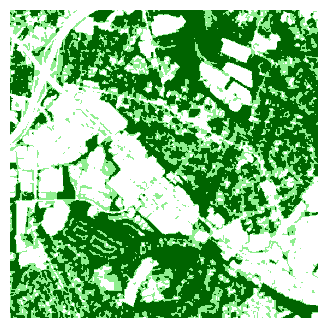

In [14]:
import matplotlib.pyplot as plt
import rasterio

# Load the .tif image
tif_path = "./image_saver/test/m_NorthCarolina_Charlotte_W_2024_2.tif"

with rasterio.open(tif_path) as src:
    image = src.read(1)  # Read the first band (for grayscale images)

#colors = ['lightblue', 'white', 'lightgreen','darkgreen']  # Seg mask (all 4 classes present)
colors = ['white', 'lightgreen','darkgreen']  # Seg mask (3 classes)
#colors = ['black', 'green','red']  # cd1 - MCD mask (3 classes)
# colors = ['black','lightgray', 'gray', 'darkgray',   # cd2 - SCD mask (13 classes)
#               'darkblue', 'green', 'darkgreen',
#               'lightblue', 'orange', 'lightgreen',
#               'blue', 'orangered', 'peachpuff']
cmap = plt.matplotlib.colors.ListedColormap(colors)

# Plot the image with a user-defined colormap
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap=cmap)

######## Adding a legend ########
#import matplotlib.patches as mpatches   
# Define the class labels
# class_labels = ['0: no change', '1: water to building', '2: water to sparse', '3: water to dense',
#                 '4: building to water', '5: building to sparse', '6: building to dense',
#                 '7: sparse to water', '8: sparse to building', '9: sparse to dense',
#                 '10: dense to water', '11: dense to building', '12: dense to sparse']

# Create a list of patches to be shown in the legend
#patches = [mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))]

# Add the legend to the plot
#plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), ncol=4,loc='upper left', borderaxespad=0., prop={'family': 'Times New Roman'})
#fig = plt.gcf()
#fig.subplots_adjust(right=0.8)
#fig.set_size_inches(1, 10)

plt.axis("off")
plt.imsave(tif_path.replace('.tif', '_colormap.png'), image, cmap=cmap)

plt.show()

## Plotting State vs Num Cities graph

### List all filenames in given folder
- useful for counting cities 

In [ ]:
import os

def get_filenames(folder_path):
    """Returns a list of filenames in the given folder."""
    return [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Example usage
folder_path = "./new_eur"  # Change this to your folder path
filenames = get_filenames(folder_path)
#print(type(filenames))


filenames2 = list(filenames)
filenames3 = []
for file in filenames2: 
    # file = os.path.splitext(os.path.basename(root_directory+file1))[0]
    # print(type(file))
    file  = file.replace("cd1_m_","")
    file = file.replace(".tif", "")
    # file = file.replace("_1","")
    # file = file.replace("_2","")
    # file = file.replace("_3","")
    # file = file.replace("_4","")
    file = file[:-2]
    if(file[-1]=="_"):
        file = file[:-1]
    filenames3.append(file)
    # print(file)

filenames4 = list(set(filenames3))
filenames4.sort()

print(len(filenames4))
# for party in filenames4:
#     print(party)

### Replace some filenames

In [ ]:
replacements = {
    'Alabama_Dayton': 'Ohio_Dayton',
    'Alabama_Cincinnati': 'Ohio_Cincinnati',
    'Alabama_Toledo': 'Ohio_Toledo',
    'Illinois_Greenbay': 'Wisconsin_Greenbay',
    'Illinois_FortWayne': 'Indiana_FortWayne',
    'Illinois_SouthBend': 'Indiana_SouthBend'
}

# Apply replacements
filenames4_replaced = [replacements.get(name, name) for name in filenames4]

#print(filenames4_replaced)

filenames4_replaced.sort()
# for party in filenames4_replaced:
#     if party == "Illinois_Greenbay":
#         print(party)
#         print("bla")

print(len(filenames4_replaced))

state_city_split = [name.split('_') for name in filenames4_replaced]
print(state_city_split)


### Plot bar graph for state vs num of cities

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt

# Count the number of cities per state
state_counts = Counter([state for state, city in state_city_split])

# Extract states and their corresponding counts
states = list(state_counts.keys())
city_counts = list(state_counts.values())

print(len(states))

# Plot the bar chart
plt.figure(figsize=(15, 7))
bars = plt.bar(states, city_counts, color='#9198db')
plt.xlabel('Countries')
plt.ylabel('Number of Cities')
plt.title('Number of Cities per Country in Europe')
plt.xticks(rotation=90)
plt.show()
